In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
import nsforest as ns
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

mouse_path = "E:/Mouse_M1/"
opossum_path = "E:/Opossum_M1/"

In [2]:
def subsample_adata(adata, number, key="leiden_intra"):
    mask = np.zeros(adata.shape[0])
    unique = np.unique(adata.obs[key])
    for un in unique:
        idx = np.where(adata.obs[key] == un)[0]
        if idx.size < number:
            print("Warning: {0} contains fewer cells than minimum, taking all cells.".format(un))
            mask[idx] = 1
        else:
            rand_idx = np.random.permutation(idx)[:number]
            mask[rand_idx] = 1
    return adata[mask == 1, :]

In [3]:
adata_mouse = sc.read_h5ad(mouse_path + "Mouse_M1_All.h5ad")
del adata_mouse.uns
del adata_mouse.obsm
del adata_mouse.varm
del adata_mouse.obsp
adata_mouse = adata_mouse[adata_mouse.obs["class"] == "glutamatergic", :]
adata_glut_mouse = sc.read_h5ad(mouse_path + "Mouse_M1_Glut_Clustered.h5ad")
adata_mouse.obs["leiden_intra"] = adata_glut_mouse.obs["leiden"]
del adata_glut_mouse

shared_genes = np.loadtxt("E:/mouse_opossum_shared_genes.csv", dtype=str)
adata_mouse = adata_mouse[:, shared_genes]
sc.pp.filter_cells(adata_mouse, min_genes=700)

C:\Users\TLab\AppData\Local\Temp\ipykernel_4008\2641156719.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mouse.obs["leiden_intra"] = adata_glut_mouse.obs["leiden"]
C:\Ryan\GitHub\scanpy\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [4]:
adata_mouse = subsample_adata(adata_mouse, 1000, key="leiden_intra")

In [5]:
adata_opossum = sc.read_h5ad(opossum_path + "Opossum_M1_All.h5ad")
del adata_opossum.uns
del adata_opossum.obsm
del adata_opossum.varm
del adata_opossum.obsp
adata_opossum = adata_opossum[adata_opossum.obs["class"] == "glutamatergic", :]
adata_glut_opossum = sc.read_h5ad(opossum_path + "Opossum_M1_Glut_Clustered.h5ad")
adata_opossum.obs["leiden_intra"] = adata_glut_opossum.obs["leiden"]
del adata_glut_opossum

shared_genes = np.loadtxt("E:/mouse_opossum_shared_genes.csv", dtype=str)
shared_genes = np.array([gene.upper() for gene in shared_genes], dtype=str)
adata_opossum = adata_opossum[:, shared_genes]
sc.pp.filter_cells(adata_opossum, min_genes=700)

C:\Users\TLab\AppData\Local\Temp\ipykernel_4008\718780750.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_opossum.obs["leiden_intra"] = adata_glut_opossum.obs["leiden"]


filtered out 2348 cells that have less than 700 genes expressed


C:\Ryan\GitHub\scanpy\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [6]:
adata_opossum = subsample_adata(adata_opossum, 1000, key="leiden_intra")

In [7]:
var_names_lower = adata_mouse.var_names
var_names_upper = []
for name in var_names_lower:
    var_names_upper.append(name.upper())
adata_mouse.var_names = var_names_upper

Concatenate AnnData objects and find highly variable genes

In [8]:
adata = adata_mouse.concatenate(adata_opossum, batch_key="concat")

c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [9]:
adata

AnnData object with n_obs × n_vars = 33724 × 10564
    obs: 'class_label', 'cluster_label', 'batch', 'n_counts', 'leiden', 'class', 'species', 'leiden_intra', 'n_genes', 'concat'
    var: 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1'

Perform PCA with Harmony batch-correction and cluster together

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


2023-05-16 16:29:18,848 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-16 16:29:28,096 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-16 16:29:28,379 - harmonypy - INFO - Iteration 1 of 20
2023-05-16 16:29:49,457 - harmonypy - INFO - Iteration 2 of 20
2023-05-16 16:30:10,325 - harmonypy - INFO - Iteration 3 of 20
2023-05-16 16:30:31,425 - harmonypy - INFO - Iteration 4 of 20
2023-05-16 16:30:52,494 - harmonypy - INFO - Iteration 5 of 20
2023-05-16 16:31:13,556 - harmonypy - INFO - Iteration 6 of 20
2023-05-16 16:31:33,952 - harmonypy - INFO - Iteration 7 of 20
2023-05-16 16:31:49,122 - harmonypy - INFO - Iteration 8 of 20
2023-05-16 16:32:02,395 - harmonypy - INFO - Iteration 9 of 20
2023-05-16 16:32:13,949 - harmonypy - INFO - Iteration 10 of 20
2023-05-16 16:32:26,281 - harmonypy - INFO - Iteration 11 of 20
2023-05-16 16:32:38,728 - harmonypy - INFO - Iteration 12 of 20
2023-05-16 16:32:52,655 - harmonypy - INFO - Converged after

computing neighbors


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_inter', the cluster labels (adata.obs, categorical) (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


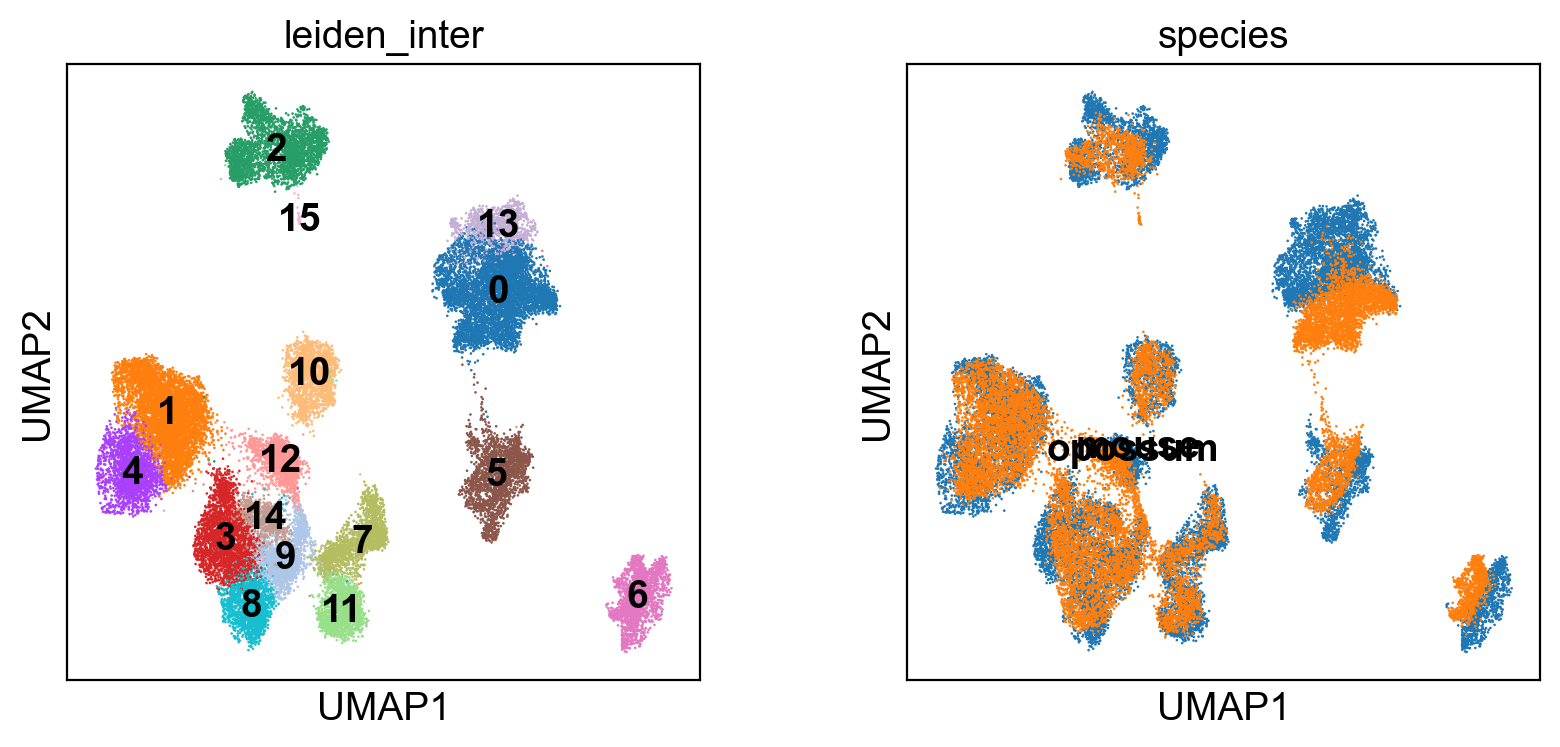

In [11]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, ["batch", "species"], theta=(4, 4), max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata, key_added="leiden_inter")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden_inter", "species"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


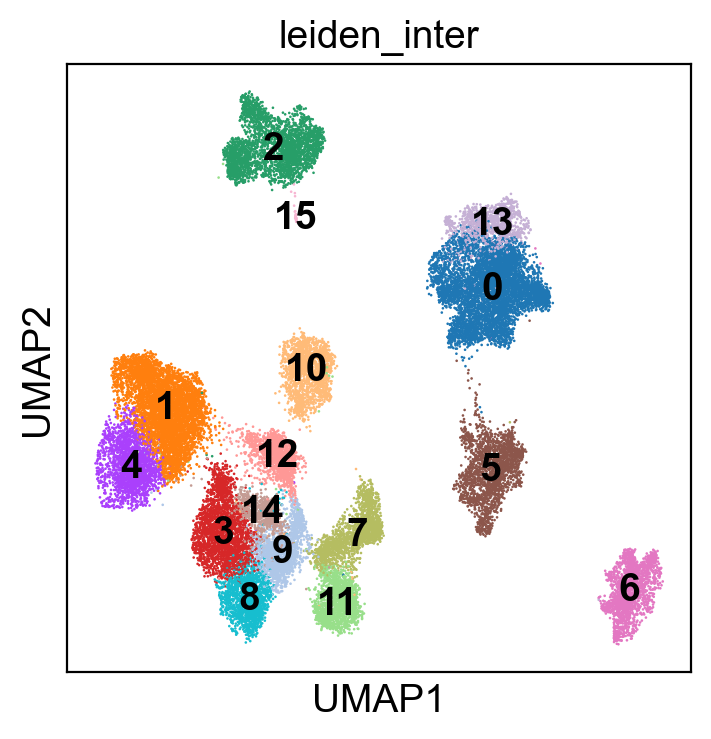

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


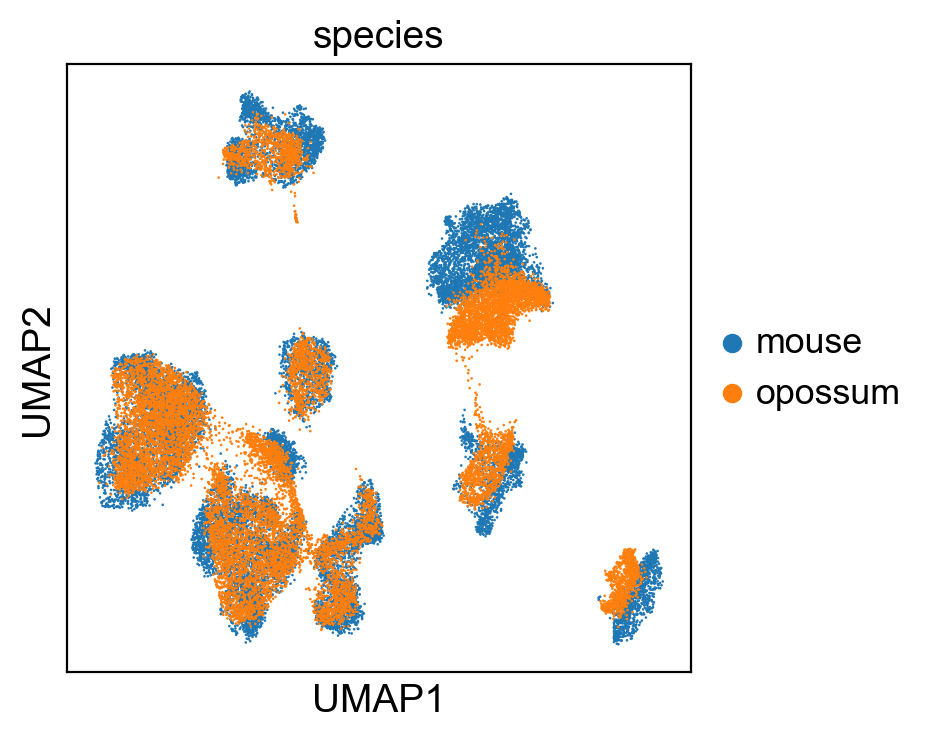

In [12]:
sc.pl.umap(adata, color=["leiden_inter"], legend_loc="on data")
sc.pl.umap(adata, color=["species"])

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


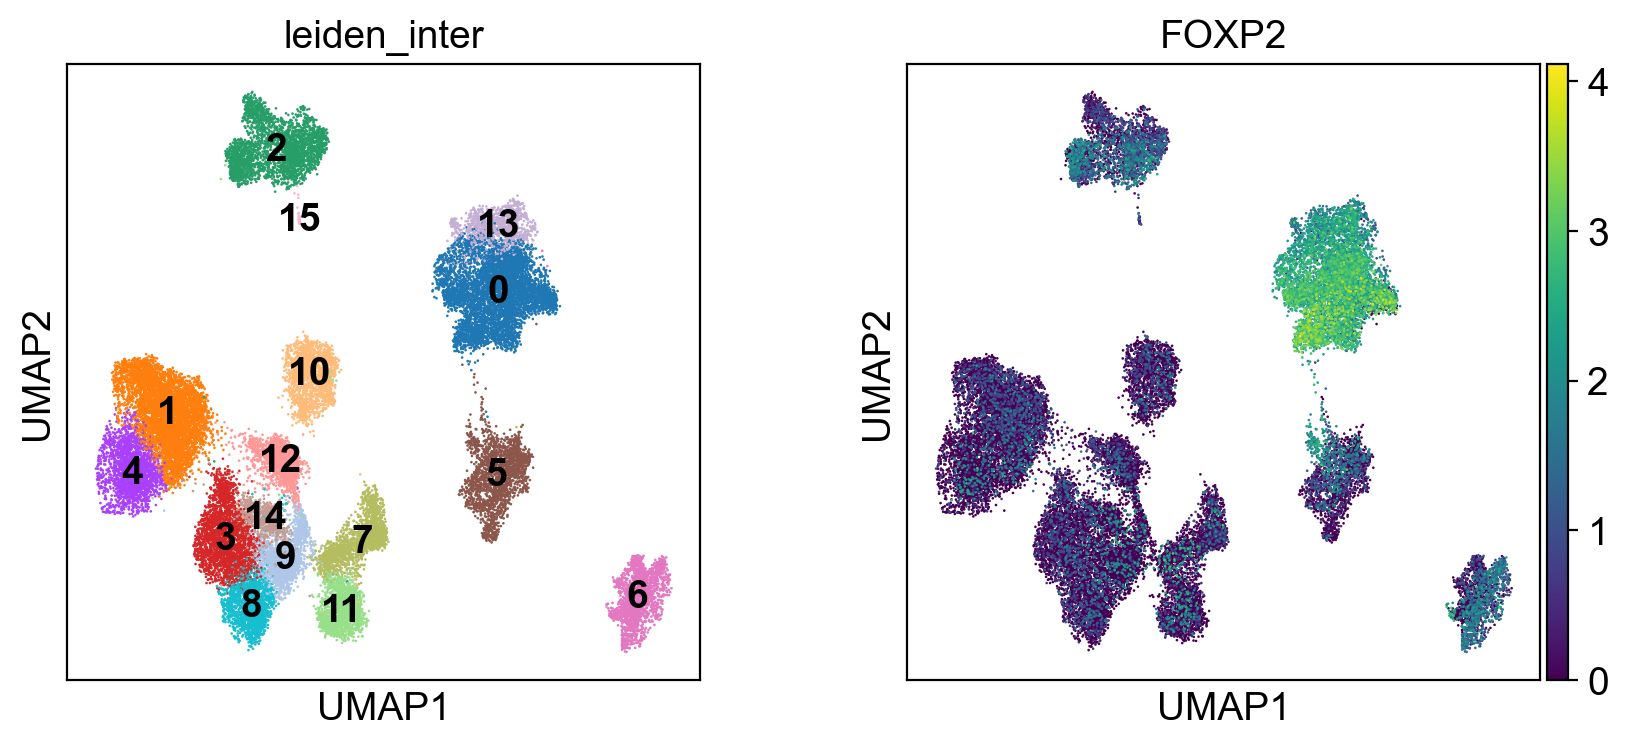

In [13]:
sc.pl.umap(adata, color=["leiden_inter", "FOXP2"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


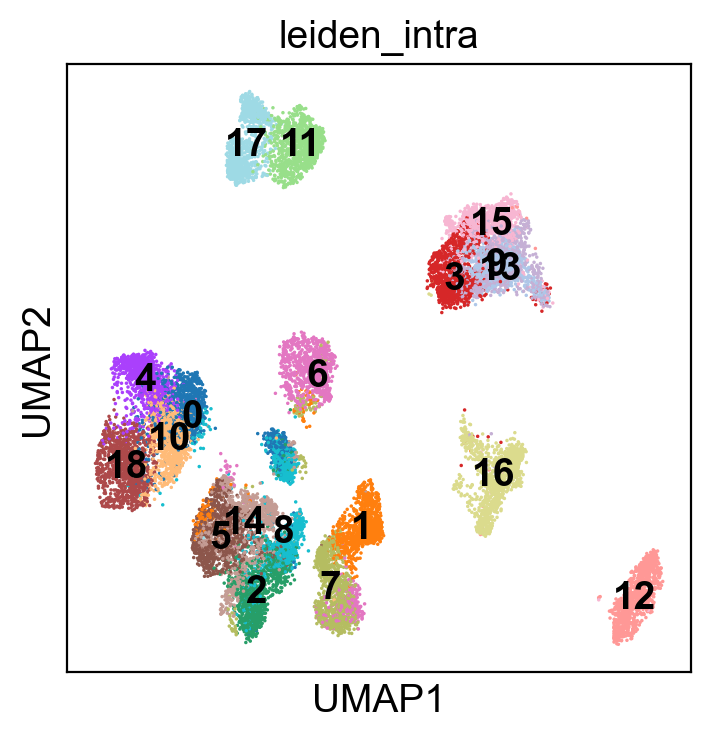

In [14]:
sc.pl.umap(adata[adata.obs["species"]=="mouse", :], color=["leiden_intra"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


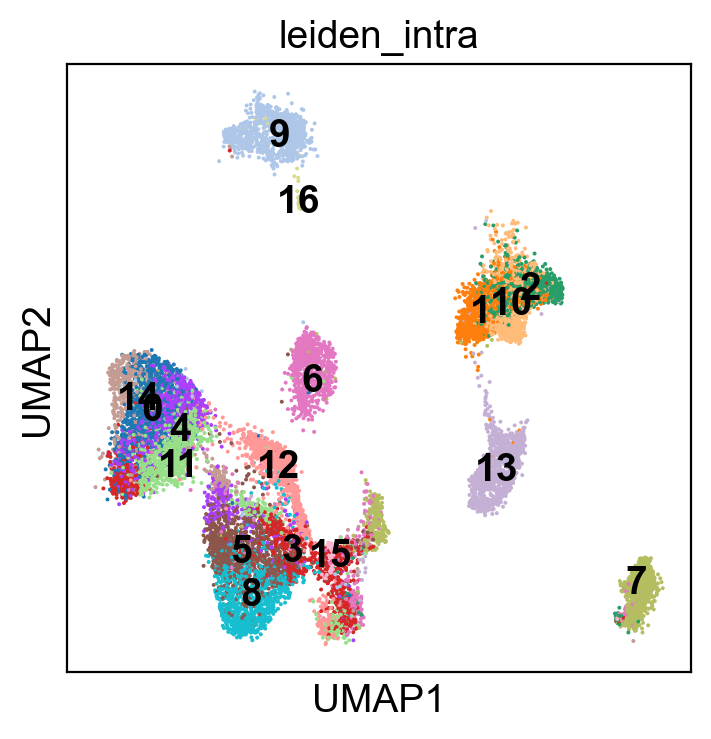

In [15]:
sc.pl.umap(adata[adata.obs["species"]=="opossum", :], color=["leiden_intra"], legend_loc="on data")